In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

### Load data

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
data = pd.read_csv("csv_data/raw_combined_2.csv") 

# get the length of section
print("Total number of texts: ", len(data['text']))
print("Total number of labels: ", len(data['label']))

#get unique labels
unique_labels = list(set(data['label']))
print("The unique labels are: ", unique_labels)

Total number of texts:  1998
Total number of labels:  1998
The unique labels are:  [0, 1]


In [10]:
# First split: 80% (train+val) and 20% (test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_idx, test_idx in split1.split(data, data['label']):
    train_val_data = data.iloc[train_val_idx]
    test_data = data.iloc[test_idx]

# Second split: 60% train and 20% validation from 80% train+val
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in split2.split(train_val_data, train_val_data['label']):
    train_data = train_val_data.iloc[train_idx]
    val_data = train_val_data.iloc[val_idx]

# Verify the splits on the labels
print("Train data: ", train_data['label'].value_counts(normalize=False))
print()
print("Validation data: ", val_data['label'].value_counts(normalize=False))
print()
print("Test data: ", test_data['label'].value_counts(normalize=False))

Train data:  label
0    664
1    534
Name: count, dtype: int64

Validation data:  label
0    222
1    178
Name: count, dtype: int64

Test data:  label
0    222
1    178
Name: count, dtype: int64


In [11]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
train_dataset = Dataset.from_dict(train_data.to_dict(orient='list'))
val_dataset = Dataset.from_dict(val_data.to_dict(orient='list'))
test_dataset = Dataset.from_dict(test_data.to_dict(orient='list'))

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
model = model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()

Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/114 [00:00<?, ?it/s]

{'loss': 0.5938, 'grad_norm': 2.034734010696411, 'learning_rate': 1.824561403508772e-05, 'epoch': 0.26}
{'loss': 0.2634, 'grad_norm': 1.365644931793213, 'learning_rate': 1.649122807017544e-05, 'epoch': 0.53}
{'loss': 0.1167, 'grad_norm': 2.262444019317627, 'learning_rate': 1.4736842105263159e-05, 'epoch': 0.79}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.047243695706129074, 'eval_accuracy': 0.99, 'eval_runtime': 26.9481, 'eval_samples_per_second': 14.843, 'eval_steps_per_second': 0.26, 'epoch': 1.0}
{'loss': 0.0765, 'grad_norm': 1.2267094850540161, 'learning_rate': 1.2982456140350879e-05, 'epoch': 1.05}
{'loss': 0.0555, 'grad_norm': 3.0101921558380127, 'learning_rate': 1.1228070175438597e-05, 'epoch': 1.32}
{'loss': 0.0222, 'grad_norm': 0.19731447100639343, 'learning_rate': 9.473684210526315e-06, 'epoch': 1.58}
{'loss': 0.0211, 'grad_norm': 7.405792236328125, 'learning_rate': 7.719298245614036e-06, 'epoch': 1.84}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.021693754941225052, 'eval_accuracy': 0.995, 'eval_runtime': 27.6521, 'eval_samples_per_second': 14.465, 'eval_steps_per_second': 0.253, 'epoch': 2.0}
{'loss': 0.033, 'grad_norm': 0.13411268591880798, 'learning_rate': 5.964912280701755e-06, 'epoch': 2.11}
{'loss': 0.0128, 'grad_norm': 0.17694099247455597, 'learning_rate': 4.210526315789474e-06, 'epoch': 2.37}
{'loss': 0.0118, 'grad_norm': 0.12361937016248703, 'learning_rate': 2.456140350877193e-06, 'epoch': 2.63}
{'loss': 0.0251, 'grad_norm': 0.3400576412677765, 'learning_rate': 7.017543859649123e-07, 'epoch': 2.89}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.019699471071362495, 'eval_accuracy': 0.995, 'eval_runtime': 27.9374, 'eval_samples_per_second': 14.318, 'eval_steps_per_second': 0.251, 'epoch': 3.0}
{'train_runtime': 612.067, 'train_samples_per_second': 5.872, 'train_steps_per_second': 0.186, 'train_loss': 0.10858123128612836, 'epoch': 3.0}


TrainOutput(global_step=114, training_loss=0.10858123128612836, metrics={'train_runtime': 612.067, 'train_samples_per_second': 5.872, 'train_steps_per_second': 0.186, 'total_flos': 476087830769664.0, 'train_loss': 0.10858123128612836, 'epoch': 3.0})

  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 0.9925
Precision: 0.9925
Recall: 0.9925
F1 Score: 0.9925


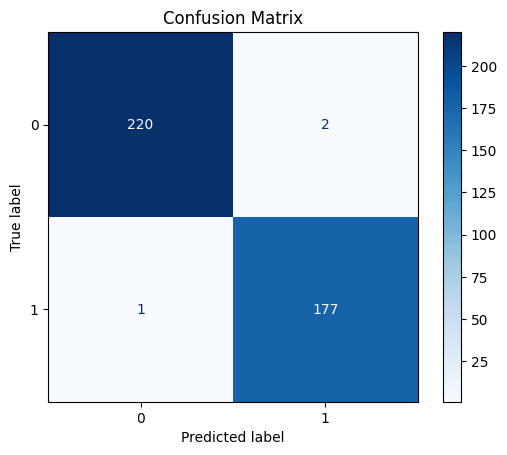

In [13]:
# Predict on the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)  # Predicted class
true_labels = predictions.label_ids  # True labels

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Replace unique_labels with your label names
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [14]:
# save the model for later use
# torch.save(model.state_dict(), "medical_modle.pth")

### Second fine-tuning

In [15]:
waste_data = pd.read_csv("csv_data/waste_40.csv")

# get the length of section
print("Total number of texts: ", len(waste_data['text']))
print("Total number of labels: ", len(waste_data['label']))

#get number of papers per label
print("The number of papers per label are: ", waste_data['label'].value_counts(normalize=False))


Total number of texts:  40
Total number of labels:  40
The number of papers per label are:  label
1    20
0    20
Name: count, dtype: int64


In [16]:
# First split: 80% (train+val) and 20% (test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=44)
for train_idx, val_idx in split1.split(waste_data, waste_data['label']):
    waste_train_data = waste_data.iloc[train_idx]
    waste_val_data = waste_data.iloc[val_idx]


# Verify the splits on the labels
print("Train data: ", waste_train_data['label'].value_counts(normalize=False))
print()
print("Validation data: ", waste_val_data['label'].value_counts(normalize=False))
print()

Train data:  label
0    10
1    10
Name: count, dtype: int64

Validation data:  label
1    10
0    10
Name: count, dtype: int64



In [17]:
waste_train_dataset = Dataset.from_dict(waste_train_data.to_dict(orient='list'))
waste_val_dataset = Dataset.from_dict(waste_val_data.to_dict(orient='list'))


# Apply tokenization
waste_train_dataset = waste_train_dataset.map(tokenize_function, batched=True)
waste_val_dataset = waste_val_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
waste_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
# model = model.to(device)
waste_model = model
for layer in waste_model.distilbert.transformer.layer[:3]:
    for param in layer.parameters():
        param.requires_grad = False
# Training arguments
waste_training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
waste_trainer = Trainer(
    model=waste_model,
    args=waste_training_args,
    train_dataset=waste_train_dataset,
    eval_dataset=waste_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
waste_trainer.train()

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.772645115852356, 'eval_accuracy': 0.75, 'eval_runtime': 0.2086, 'eval_samples_per_second': 95.86, 'eval_steps_per_second': 4.793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7095397114753723, 'eval_accuracy': 0.8, 'eval_runtime': 0.1939, 'eval_samples_per_second': 103.147, 'eval_steps_per_second': 5.157, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6590267419815063, 'eval_accuracy': 0.75, 'eval_runtime': 0.204, 'eval_samples_per_second': 98.022, 'eval_steps_per_second': 4.901, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6191600561141968, 'eval_accuracy': 0.75, 'eval_runtime': 0.2017, 'eval_samples_per_second': 99.175, 'eval_steps_per_second': 4.959, 'epoch': 4.0}
{'loss': 0.9881, 'grad_norm': 11.530113220214844, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5863049626350403, 'eval_accuracy': 0.75, 'eval_runtime': 0.1435, 'eval_samples_per_second': 139.354, 'eval_steps_per_second': 6.968, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5641711950302124, 'eval_accuracy': 0.75, 'eval_runtime': 0.1435, 'eval_samples_per_second': 139.352, 'eval_steps_per_second': 6.968, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5514840483665466, 'eval_accuracy': 0.75, 'eval_runtime': 0.1435, 'eval_samples_per_second': 139.356, 'eval_steps_per_second': 6.968, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5450667142868042, 'eval_accuracy': 0.75, 'eval_runtime': 0.1415, 'eval_samples_per_second': 141.324, 'eval_steps_per_second': 7.066, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5414422750473022, 'eval_accuracy': 0.75, 'eval_runtime': 0.144, 'eval_samples_per_second': 138.862, 'eval_steps_per_second': 6.943, 'epoch': 9.0}
{'loss': 0.4313, 'grad_norm': 4.6971211433410645, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5398691892623901, 'eval_accuracy': 0.75, 'eval_runtime': 0.1391, 'eval_samples_per_second': 143.817, 'eval_steps_per_second': 7.191, 'epoch': 10.0}
{'train_runtime': 12.8119, 'train_samples_per_second': 15.611, 'train_steps_per_second': 1.561, 'train_loss': 0.7096907615661621, 'epoch': 10.0}


TrainOutput(global_step=20, training_loss=0.7096907615661621, metrics={'train_runtime': 12.8119, 'train_samples_per_second': 15.611, 'train_steps_per_second': 1.561, 'total_flos': 26493479731200.0, 'train_loss': 0.7096907615661621, 'epoch': 10.0})

  0%|          | 0/1 [00:00<?, ?it/s]

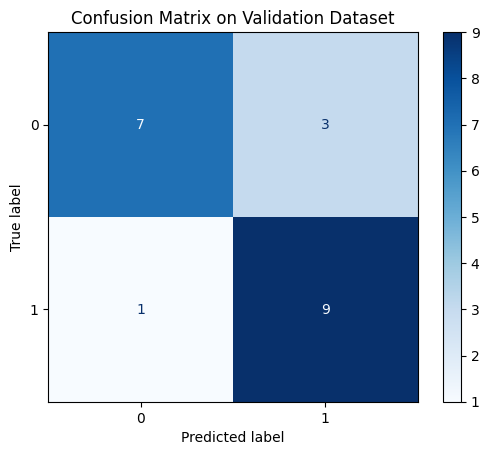

In [18]:
# Predict on the validation dataset
predictions = waste_trainer.predict(waste_val_dataset)

# Extract logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=waste_model.config.id2label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Dataset")
plt.show()

In [19]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8000
Precision: 0.8125
Recall: 0.8000
F1 Score: 0.7980


### infer


## Below is to infer the pdfs in a folder

In [20]:
import os
import torch
import pandas as pd
import fitz  # PyMuPDF
def extract_text_from_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            text += page.get_text()
        return text
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return ""

def predict_label_for_pdf(pdf_path, model, tokenizer, device):
    # Extract text from the PDF
    text = extract_text_from_pdf(pdf_path)
    if not text.strip():
        print(f"No text extracted from {pdf_path}")
        return None

    # Tokenize the text
    inputs = tokenizer(
        text, 
        padding="max_length", 
        truncation=True, 
        max_length=512, 
        return_tensors="pt"
    )
    
    # Move tensors to the device (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Predict label
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

def process_pdfs_after_training(directory_path, output_csv, model, tokenizer, device):
    results = []

    # Iterate through all PDF files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(directory_path, filename)
            print(f"Processing {filename}...")

            # Predict label for the PDF
            predicted_label = predict_label_for_pdf(pdf_path, model, tokenizer, device)
            
            if predicted_label is not None:
                results.append({"filename": filename, "predicted_label": predicted_label})

    # Save the results to a CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

# Directory containing the PDFs
pdfs_dir = "../Medical/waste_data/Yes"
output_csv_path = "../Medical/New_Data/predicted_labels.csv"

# Run the process using the trained model
process_pdfs_after_training(
    directory_path=pdfs_dir,
    output_csv=output_csv_path,
    model=waste_model,       # The model you trained
    tokenizer=tokenizer,     # Tokenizer used during training
    device=device            # Device (GPU or CPU)
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../Medical/waste_data/Yes'